---
Cell 1 – Imports and helper functions
---
---

In [1]:
# Cell 1: Imports and helper functions (band-pass design and filtering)
# This cell defines a Butterworth band-pass filter and a function to apply it.

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch

# Design a Butterworth band-pass filter
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Apply the band-pass filter to the data using filtfilt (zero-phase filtering)
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y


---
Cell 2 – Create a synthetic EEG signal
---
---

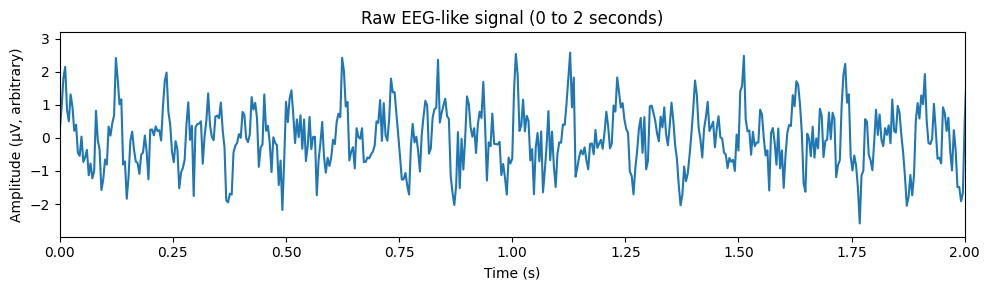

In [2]:
# Cell 2: Create a synthetic EEG signal with multiple frequency components and noise
# This cell simulates an EEG-like signal containing alpha, beta, and out-of-band components.

fs = 250  # Sampling rate in Hz
duration = 10  # Duration in seconds
t = np.arange(0, duration, 1/fs)

rng = np.random.RandomState(42)

# Frequency components:
# 10 Hz (alpha), 18 Hz (low beta), 26 Hz (beta), 40 Hz (out of 8-35 Hz band)
sig_alpha = 0.7 * np.sin(2 * np.pi * 10 * t)
sig_beta1 = 0.5 * np.sin(2 * np.pi * 18 * t)
sig_beta2 = 0.4 * np.sin(2 * np.pi * 26 * t)
sig_outband = 0.4 * np.sin(2 * np.pi * 40 * t)  # Outside the 8-35 Hz band

noise = 0.5 * rng.randn(len(t))

# Synthetic EEG signal = sum of components + noise
eeg = sig_alpha + sig_beta1 + sig_beta2 + sig_outband + noise

# Plot the raw signal (short segment for visualization)
plt.figure(figsize=(10, 3))
plt.plot(t, eeg)
plt.xlim(0, 2)  # Show only the first 2 seconds
plt.title("Raw EEG-like signal (0 to 2 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV, arbitrary)")
plt.tight_layout()
plt.show()


---
Cell 3 – Apply a single wide band-pass filter (8–35 Hz)
---
---

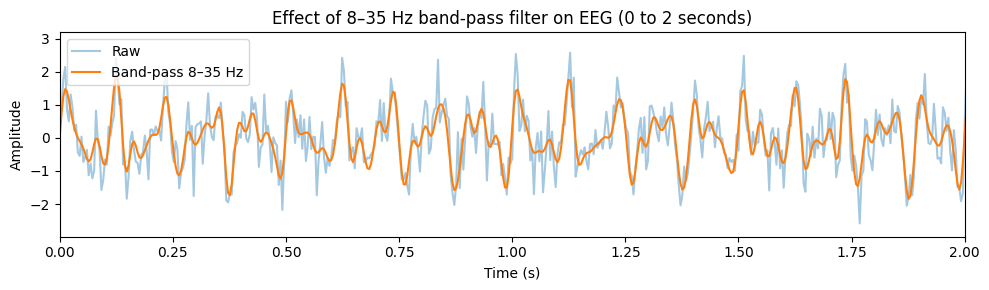

In [3]:
# Cell 3: Apply a single wide band-pass filter from 8 to 35 Hz
# This cell filters the signal once using the full 8-35 Hz band.

low_full = 8
high_full = 35

eeg_bp_full = bandpass_filter(eeg, low_full, high_full, fs, order=4)

plt.figure(figsize=(10, 3))
plt.plot(t, eeg, label="Raw", alpha=0.4)
plt.plot(t, eeg_bp_full, label="Band-pass 8–35 Hz")
plt.xlim(0, 2)
plt.title("Effect of 8–35 Hz band-pass filter on EEG (0 to 2 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()


---
Cell 4 – Apply the filter bank (six sub-bands)
---
---

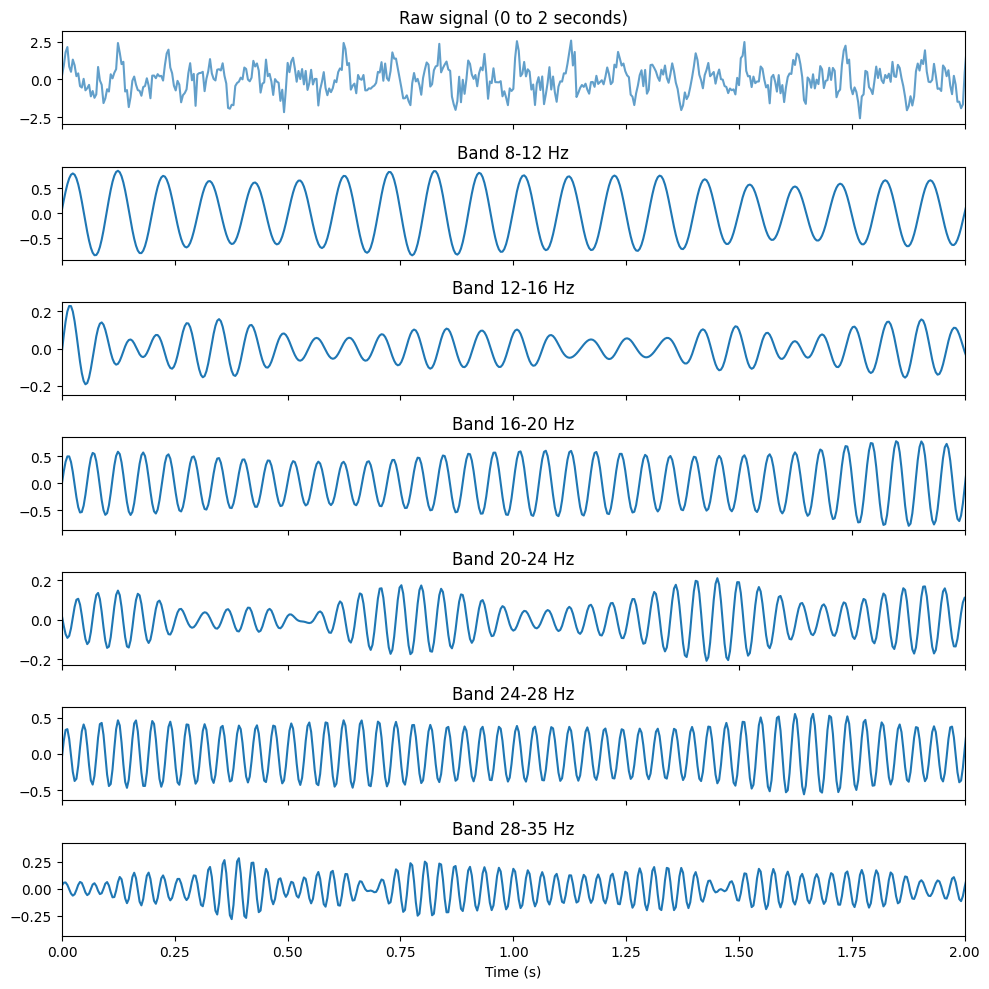

In [4]:
# Cell 4: Apply a filter bank with 6 non-overlapping sub-bands
# This cell splits the 8–35 Hz range into 6 bands and filters the signal for each band.

bands = [
    (8, 12),
    (12, 16),
    (16, 20),
    (20, 24),
    (24, 28),
    (28, 35)
]

band_signals = {}

for (low, high) in bands:
    band_name = f"{low}-{high} Hz"
    band_signals[band_name] = bandpass_filter(eeg, low, high, fs, order=4)

# Plot a segment of each band-filtered signal
fig, axes = plt.subplots(len(bands) + 1, 1, figsize=(10, 10), sharex=True)

axes[0].plot(t, eeg, label="Raw", alpha=0.7)
axes[0].set_title("Raw signal (0 to 2 seconds)")
axes[0].set_xlim(0, 2)

for i, (name, sig) in enumerate(band_signals.items(), start=1):
    axes[i].plot(t, sig)
    axes[i].set_title(f"Band {name}")
    axes[i].set_xlim(0, 2)

plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()


---
Cell 5 – Compare spectral content (PSD) of filters
---
---

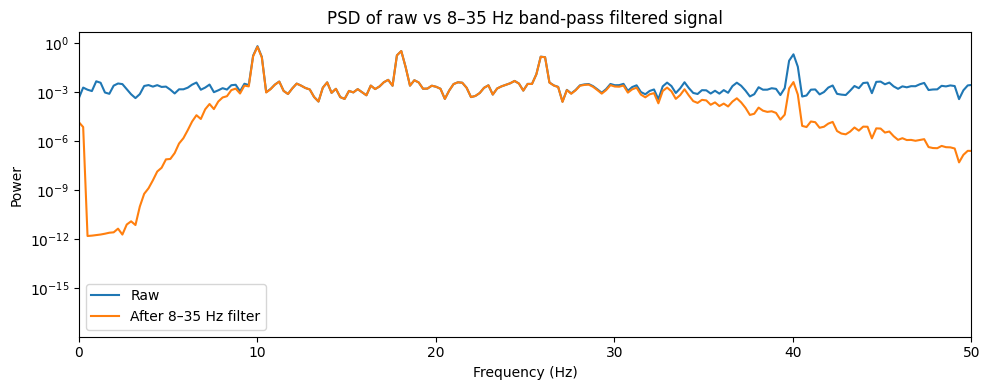

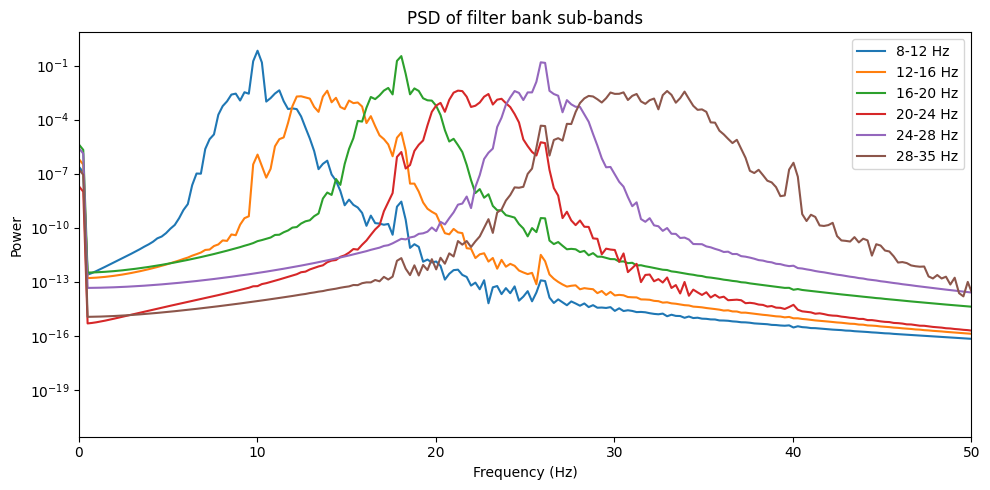

In [5]:
# Cell 5: Compute and compare the power spectral density (PSD)
# This cell uses Welch's method to show what each filter does in the frequency domain.

# PSD of raw signal
f_raw, Pxx_raw = welch(eeg, fs=fs, nperseg=1024)

# PSD of the wide 8–35 Hz band-pass
f_full, Pxx_full = welch(eeg_bp_full, fs=fs, nperseg=1024)

plt.figure(figsize=(10, 4))
plt.semilogy(f_raw, Pxx_raw, label="Raw")
plt.semilogy(f_full, Pxx_full, label="After 8–35 Hz filter")
plt.xlim(0, 50)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("PSD of raw vs 8–35 Hz band-pass filtered signal")
plt.legend()
plt.tight_layout()
plt.show()

# PSD for each sub-band in the filter bank
plt.figure(figsize=(10, 5))
for name, sig in band_signals.items():
    f, Pxx = welch(sig, fs=fs, nperseg=1024)
    plt.semilogy(f, Pxx, label=name)

plt.xlim(0, 50)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("PSD of filter bank sub-bands")
plt.legend()
plt.tight_layout()
plt.show()


---
Cell 6 – Compare wide filter vs sum of filter bank outputs
---
---

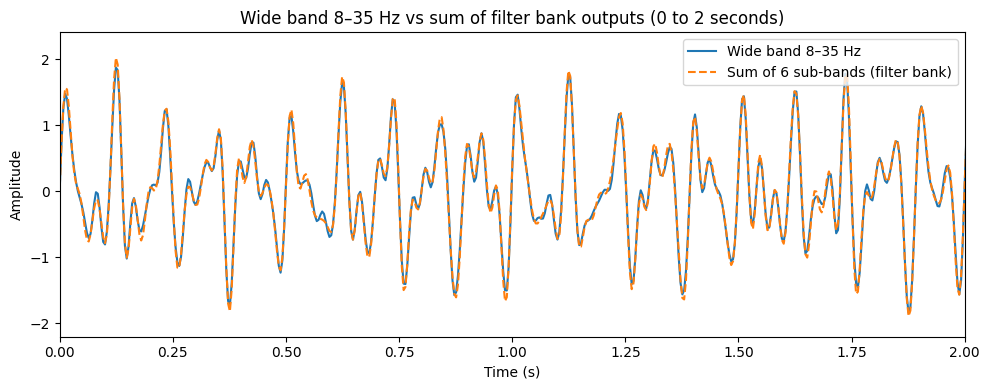

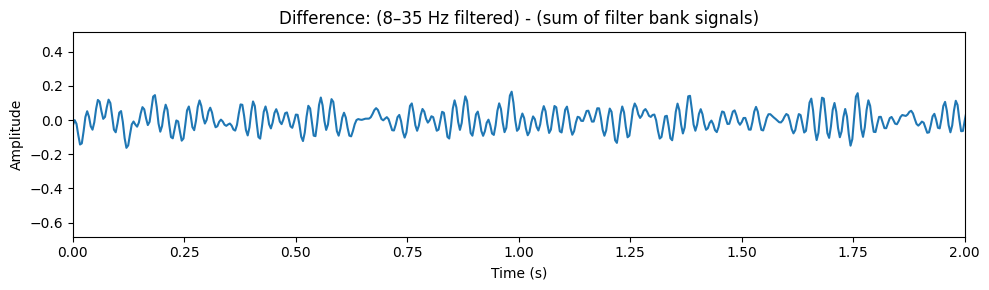

RMS difference between wide-band and filter-bank-sum signals: 0.06995157491371835


In [6]:
# Cell 6: Compare the wide 8–35 Hz filter with the sum of all filter bank outputs
# This cell shows how similar the wide-band filtered signal is to the sum of the sub-band signals.

# Sum of all sub-band signals
eeg_fb_sum = np.zeros_like(eeg)
for sig in band_signals.values():
    eeg_fb_sum += sig

# Time-domain comparison (short segment)
plt.figure(figsize=(10, 4))
plt.plot(t, eeg_bp_full, label="Wide band 8–35 Hz")
plt.plot(t, eeg_fb_sum, '--', label="Sum of 6 sub-bands (filter bank)")
plt.xlim(0, 2)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Wide band 8–35 Hz vs sum of filter bank outputs (0 to 2 seconds)")
plt.legend()
plt.tight_layout()
plt.show()

# Plot the difference between the two signals
diff = eeg_bp_full - eeg_fb_sum

plt.figure(figsize=(10, 3))
plt.plot(t, diff)
plt.xlim(0, 2)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Difference: (8–35 Hz filtered) - (sum of filter bank signals)")
plt.tight_layout()
plt.show()

# Compute RMS difference as a quantitative measure
rms_diff = np.sqrt(np.mean(diff**2))
print("RMS difference between wide-band and filter-bank-sum signals:", rms_diff)


---
Cell 7 – Frequency spectrum (FFT) of raw, wide-band, and filter-bank sum
---
---

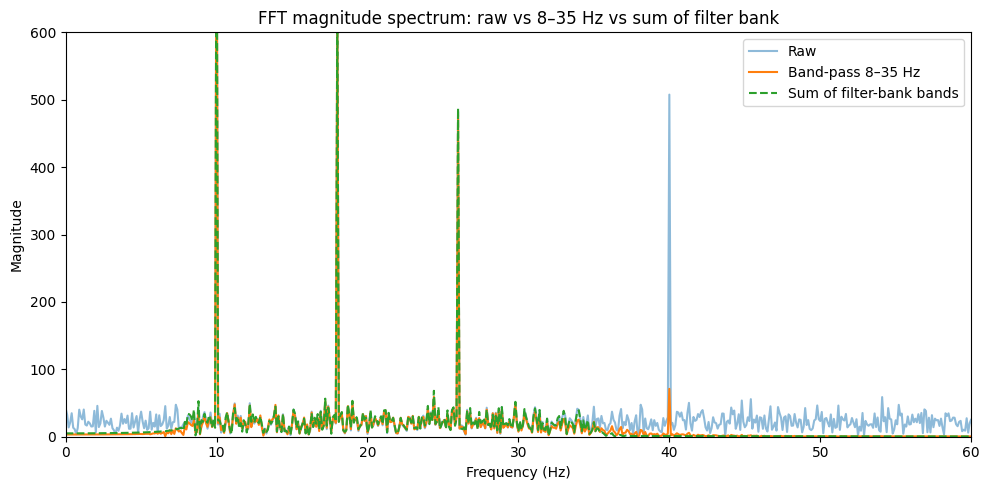

In [7]:
# Cell 7: Frequency spectrum (FFT) of raw, wide-band, and filter-bank-sum signals
# This cell computes the magnitude spectrum using FFT and compares different filtered versions.

# Compute FFT frequency axis
N = len(eeg)
freqs = np.fft.rfftfreq(N, d=1/fs)

# Compute magnitude spectra
E_raw = np.abs(np.fft.rfft(eeg))
E_full = np.abs(np.fft.rfft(eeg_bp_full))
E_fb_sum = np.abs(np.fft.rfft(eeg_fb_sum))

plt.figure(figsize=(10, 5))
plt.plot(freqs, E_raw, label="Raw", alpha=0.5)
plt.plot(freqs, E_full, label="Band-pass 8–35 Hz")
plt.plot(freqs, E_fb_sum, '--', label="Sum of filter-bank bands")
plt.xlim(0, 60)  # focus on 0–60 Hz
plt.ylim(0, 600)  # focus on 0–60 Hz
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("FFT magnitude spectrum: raw vs 8–35 Hz vs sum of filter bank")
plt.legend()
plt.tight_layout()
plt.show()


---
Cell 8 – Frequency spectrum of each individual sub-band
---
---

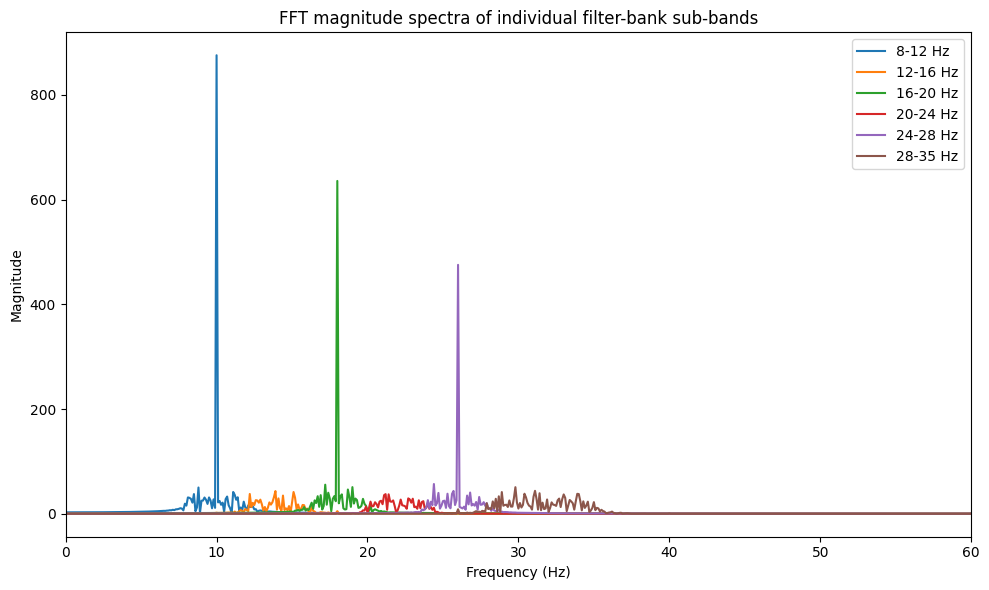

In [8]:
# Cell 8: Frequency spectrum (FFT) of each filter-bank sub-band
# This cell shows how each band-pass filter isolates a specific portion of the spectrum.

plt.figure(figsize=(10, 6))

for name, sig in band_signals.items():
    spectrum = np.abs(np.fft.rfft(sig))
    plt.plot(freqs, spectrum, label=name)

plt.xlim(0, 60)  # focus on 0–60 Hz
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("FFT magnitude spectra of individual filter-bank sub-bands")
plt.legend()
plt.tight_layout()
plt.show()
